In [4]:
def data_cleaner(path):
    '''
    - Takes the path of the file
    - Converts it into a pandas dataframe
    - Drops unimportant columns
    - Renames columns
    - Changes capitalization
    - Returns the dataframe
    '''
    #import the libraries
    import pandas as pd
    import numpy as np
    #read the table as a dataframe using pandas
    df = pd.read_excel(path)
    #drop unimportant columns
    df.drop(columns = ['Ticker', 'SIC'], inplace = True)
    #change column names
    df.rename(columns = {'Company Name':'company_name', 'Location':'location', 'Location Type':'location_type', 'Sales':'sales', 'URL':'url', 'Phone Number':'phone_number'}, inplace = True)
    #change capitalization
    df['company_name'] = df['company_name'].str.title()
    df['location'] = df['location'].str.title()
    df['url'] = df['url'].str.lower()
    return df    

In [6]:
def data_miner(path):
    '''
    - Takes path name
    - data_cleaner() generates a pandas dataframe and cleans the data
    - data_miner() does the necesary analyses (makes a df out of headquarters, removes duplicates, removes companies with 0 sales, amd saves the df as a csv to directory)
    - Also returns a df
    '''
    #import libraries
    import pandas as pd
    import numpy as np
    import re
    import os
    #use the data_cleaner function to do basic cleaning of the data
    data_cleaner(path)
    #use the dataframe generated from data_cleaner for analysis
    #find the headquarters
    df =  data_cleaner(path)
    df_hq = df.loc[df['location_type'] == 'Headquarters']
    df_hq.reset_index(drop = True, inplace = True)
    #find the duplicates
    df_hq['bool'] = df_hq.duplicated(subset = ['company_name'], keep = 'first')
    #drop the duplicates
    for i,j in df_hq.iterrows():
        if j['bool'] == True:
            df_hq.drop(i, axis = 0, inplace = True)
    df_hq.drop(columns = ['bool'], inplace = True)
    # #drop companies that have 0 sales
    # #sales column is a string, convert into float
    df_hq['sales'] = df_hq['sales'].str.replace('[$,]','',regex = True)
    df_hq['sales'] = df_hq['sales'].astype(float).astype(int)
    for i,j in df_hq.iterrows():
        if j['sales'] == 0.0:
            df_hq.drop(i, axis = 0, inplace = True)
    df_hq.reset_index(drop = True, inplace = True)
    #saving file to directory as a csv
    outdir = './Project_OPTEL_Asia/output'
    try:
        os.makedirs(outdir)
    except FileExistsError:
        pass
    outname = input('Enter file name')
    fullname = os.path.join(outdir,outname)
    df_hq.to_csv(fullname, encoding = 'utf-8', index = False)
    return df_hq

In [161]:
def plotme(df):
    '''
    - mushrooms() takes the file path 
    - data_miner() cleans the data and does the necessary analyses
    - mushroom() then plots a graph using the matplotlib library
    '''
    #imports
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    #data_miner takes the file path, cleans it, and generates a csv and a dataframe
    #use groupby to generate the a dataframe for the bar plot
    df_c = pd.DataFrame(df.groupby('location').count()['company_name'])
    #plot the barplot using matplotlib
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['figure.facecolor'] = 'white'
    plt.figure(figsize = (25,25)) 
    plt.barh(df_c.index, df_c['company_name'])
    a = input('Enter x-label')
    plt.xlabel(a)
    b = input('Enter y-label')
    plt.ylabel(b)
    c = input('Enter chart title')
    plt.title(c)
    return plt.show()

In [1]:
def connpost():
    '''
    - This function connects to the postgres database
    - User can input the name of the database
    - User can also input the name of the table
    - The function also copies the content of the dataframe to the table in the postgres database
    - User can then query the database on pgadmin4
    '''
    ## Connecting to a Postgres database
    #imports
    import psycopg2
    #establish connection to pgadmin4 to create a database
    host = 'localhost'
    dbname = 'postgres'
    user = 'postgres'
    password = 'password'
    conn_string = 'host=%s dbname=%s user=%s password=%s' % (host, dbname, user, password)
    conn = psycopg2.connect(conn_string)
    conn.autocommit = True
    cursor = conn.cursor()
    a = input('enter db name:')
    try:
        sql_query = 'create database ' + a
        cursor.execute(sql_query)
    except:
        sql_query = 'revoke connect on database ' +a +' from public'
        cursor.execute(sql_query)
        sql_query = '''SELECT pg_terminate_backend(pg_stat_activity.pid)
                        FROM pg_stat_activity
                        WHERE pg_stat_activity.datname = ''' "'"+a +"'"
        cursor.execute(sql_query)
        sql_query = 'drop database if exists ' + a
        cursor.execute(sql_query)
        sql_query = 'create database ' + a
        cursor.execute(sql_query)
    print('db created')
    conn.close()

    #establish connection to db
    host = 'localhost'
    dbname = a
    user = 'postgres'
    password = 'Global@7'
    conn_string = 'host=%s dbname=%s user=%s password=%s' % (host, dbname, user, password)
    conn = psycopg2.connect(conn_string)
    cursor = conn.cursor()
    print('connected to ' +a)

    #creating table in the db
    table_name = input('enter table name:')
    try:
        sql_query = "create table " +table_name +"""(
        company_name varchar,
        location varchar,
        location_type varchar,
        sales bigint,
        url varchar,
        phone_number float)"""
        print(sql_query)
        cursor.execute(sql_query)
    except:
        sql_query = 'drop table if exists ' +table_name
        cursor.execute(sql_query)
        sql_query = "create table " +table_name +"""(
        company_name varchar,
        location varchar,
        location_type varchar,
        sales bigint,
        url varchar,
        phone_number float)"""
        cursor.execute(sql_query)
    conn.commit()
    print('Table created')
    # open the file that has been created
    outdir = './Project_OPTEL_Asia/output/'
    outname = input('enter the file name that you want to open (with its extension):')
    fullname = os.path.join(outdir,outname)
    file = open(fullname)
    file
    sql_query = 'copy ' +table_name +''' from stdin with
    csv
    header
    delimiter as ','
    '''
    cursor.copy_expert(sql = sql_query, file = file)
    print('File copied')
    conn.commit()
    cursor.close()
    file.close()

In [163]:
data_miner('Project_OPTEL_Asia/china_raw_data.xlsx')

Enter file name china_data.csv


company_name         location  \
0                  China Nat Ional Petroleum Corporation   Beijing(China)   
1                        China Petrochemical Corporation   Beijing(China)   
2                 China Petroleum & Chemical Corporation   Beijing(China)   
3                            Petro China Company Limited   Beijing(China)   
4      All China Federation Of Supply And Marketing C...   Beijing(China)   
...                                                  ...              ...   
14530  Zhonghan Chancheng Ecology Construction Co., Ltd.  Zhejiang(China)   
14531        Zhuji Zhanrong Garden Engineering Co., Ltd.  Zhejiang(China)   
14532       Zhumadian Construction Engineering Co., Ltd.     Henan(China)   
14533                 Zhongyi City Development Co., Ltd.     Anhui(China)   
14534         Yunnan Duxinyuan Medical Service Co., Ltd.    Yunnan(China)   

      location_type         sales                    url  phone_number  
0      Headquarters  439113966449        www.cnpc.com.cn  1.059985e+09  
1      Headquarters  436333387593   www.sinopecgroup.com  1.059969e+09  
2      Headquarters  428729075280        www.sinopec.com  1.059960e+09  
3      Headquarters  408936470580  www.petrochina.com.cn           NaN  
4      Headquarters  357977400000                    NaN  1.066050e+09  
...             ...           ...                    ...           ...  
14530  Headquarters       1371170                    NaN           NaN  
14531  Headquarters       1371170                    NaN           NaN  
14532  Headquarters       1371170       www.zmdsctjt.com           NaN  
14533  Headquarters        804232                    NaN  5.516344e+10  
14534  Headquarters        757972                    NaN           NaN  

[14535 rows x 6 columns]

Enter file name china_data.csv
Enter x-label No. of companies
Enter y-label Cities
Enter chart title China companies


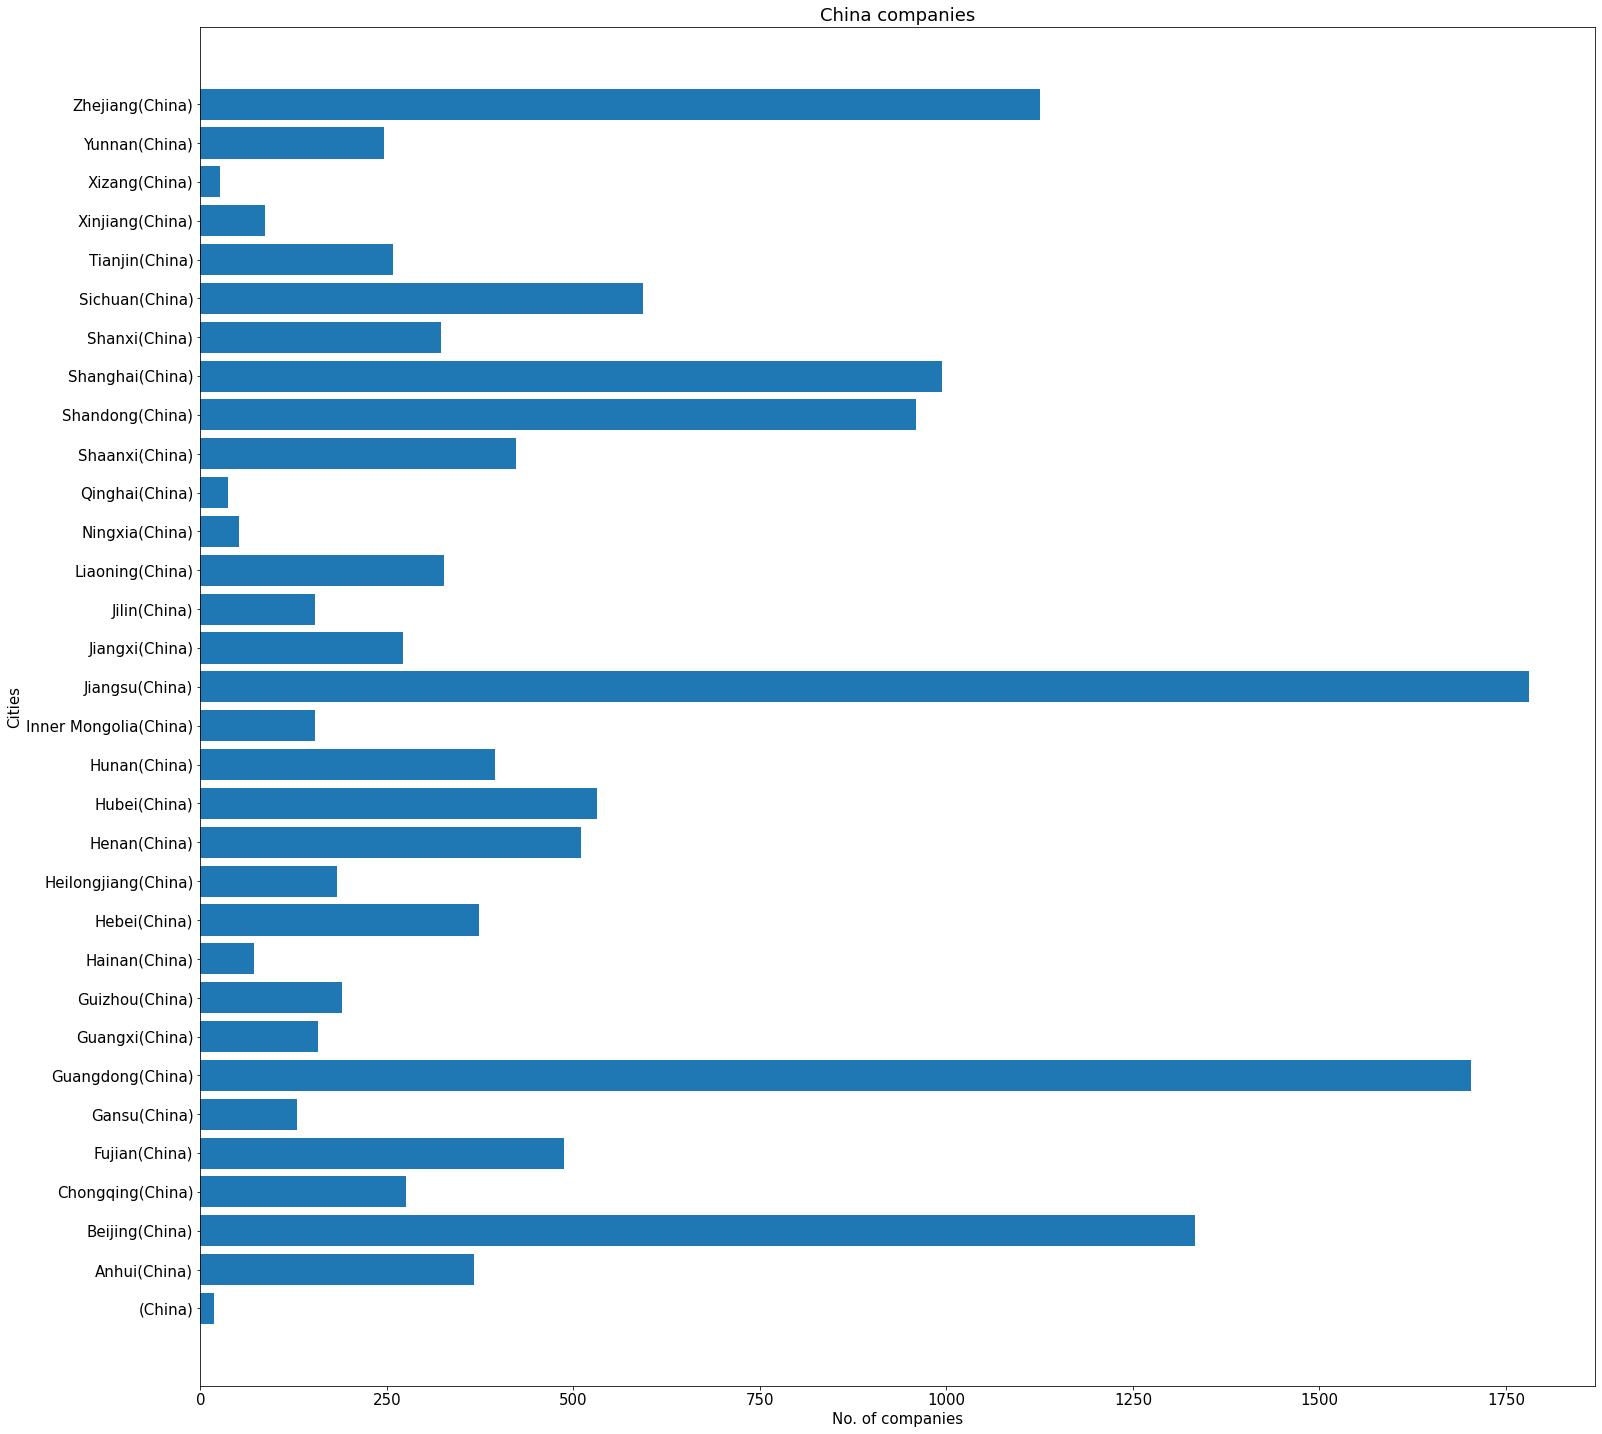

In [164]:
plotme(data_miner('Project_OPTEL_Asia/china_raw_data.xlsx'))

In [165]:
connpost()

enter db name: db_china


db created
connected to db_china


enter table name: china_companies


create table china_companies(
        company_name varchar,
        location varchar,
        location_type varchar,
        sales bigint,
        url varchar,
        phone_number float)
Table created


enter the file name that you want to open (with its extension): china_data.csv


File copied


In [166]:
data_miner('Project_OPTEL_Asia/india_raw_data.xlsx')

Enter file name india_data.csv


company_name            location  \
0         Maithri Laboratories Private Limited    Telangana(India)   
1                     Aurobindo Pharma Limited    Telangana(India)   
2              Dr.Reddy'S Laboratories Limited    Telangana(India)   
3                   Mylan Laboratories Limited    Telangana(India)   
4        Sun Pharmaceutical Industries Limited  Maharashtra(India)   
...                                        ...                 ...   
3929            Crystal Pharma Private Limited    Karnataka(India)   
3930            Curezen Pharma Private Limited    Telangana(India)   
3931    Emsons Pharmaceuticals Private Limited  West Bengal(India)   
3932           Hanaka Organics Private Limited  Maharashtra(India)   
3933  Herbochem Remedies India Private Limited  West Bengal(India)   

     location_type        sales                url  phone_number  
0     Headquarters  71883695016    www.msnlabs.com  4.030439e+09  
1     Headquarters   2156488488  www.aurobindo.com  4.066725e+09  
2     Headquarters   1837091536   www.drreddys.com  4.049002e+09  
3     Headquarters   1770625276       www.mylan.in  4.023551e+09  
4     Headquarters   1735291177  www.sunpharma.com  2.243242e+09  
...            ...          ...                ...           ...  
3929  Headquarters       879534                NaN  8.362211e+09  
3930  Headquarters       879534                NaN  9.886250e+09  
3931  Headquarters       879534                NaN           NaN  
3932  Headquarters       879534                NaN  2.225164e+09  
3933  Headquarters       879534                NaN  9.831191e+09  

[3934 rows x 6 columns]

Enter file name india_data.csv
Enter x-label No. of companies
Enter y-label Cities/States
Enter chart title Pharma companies in India


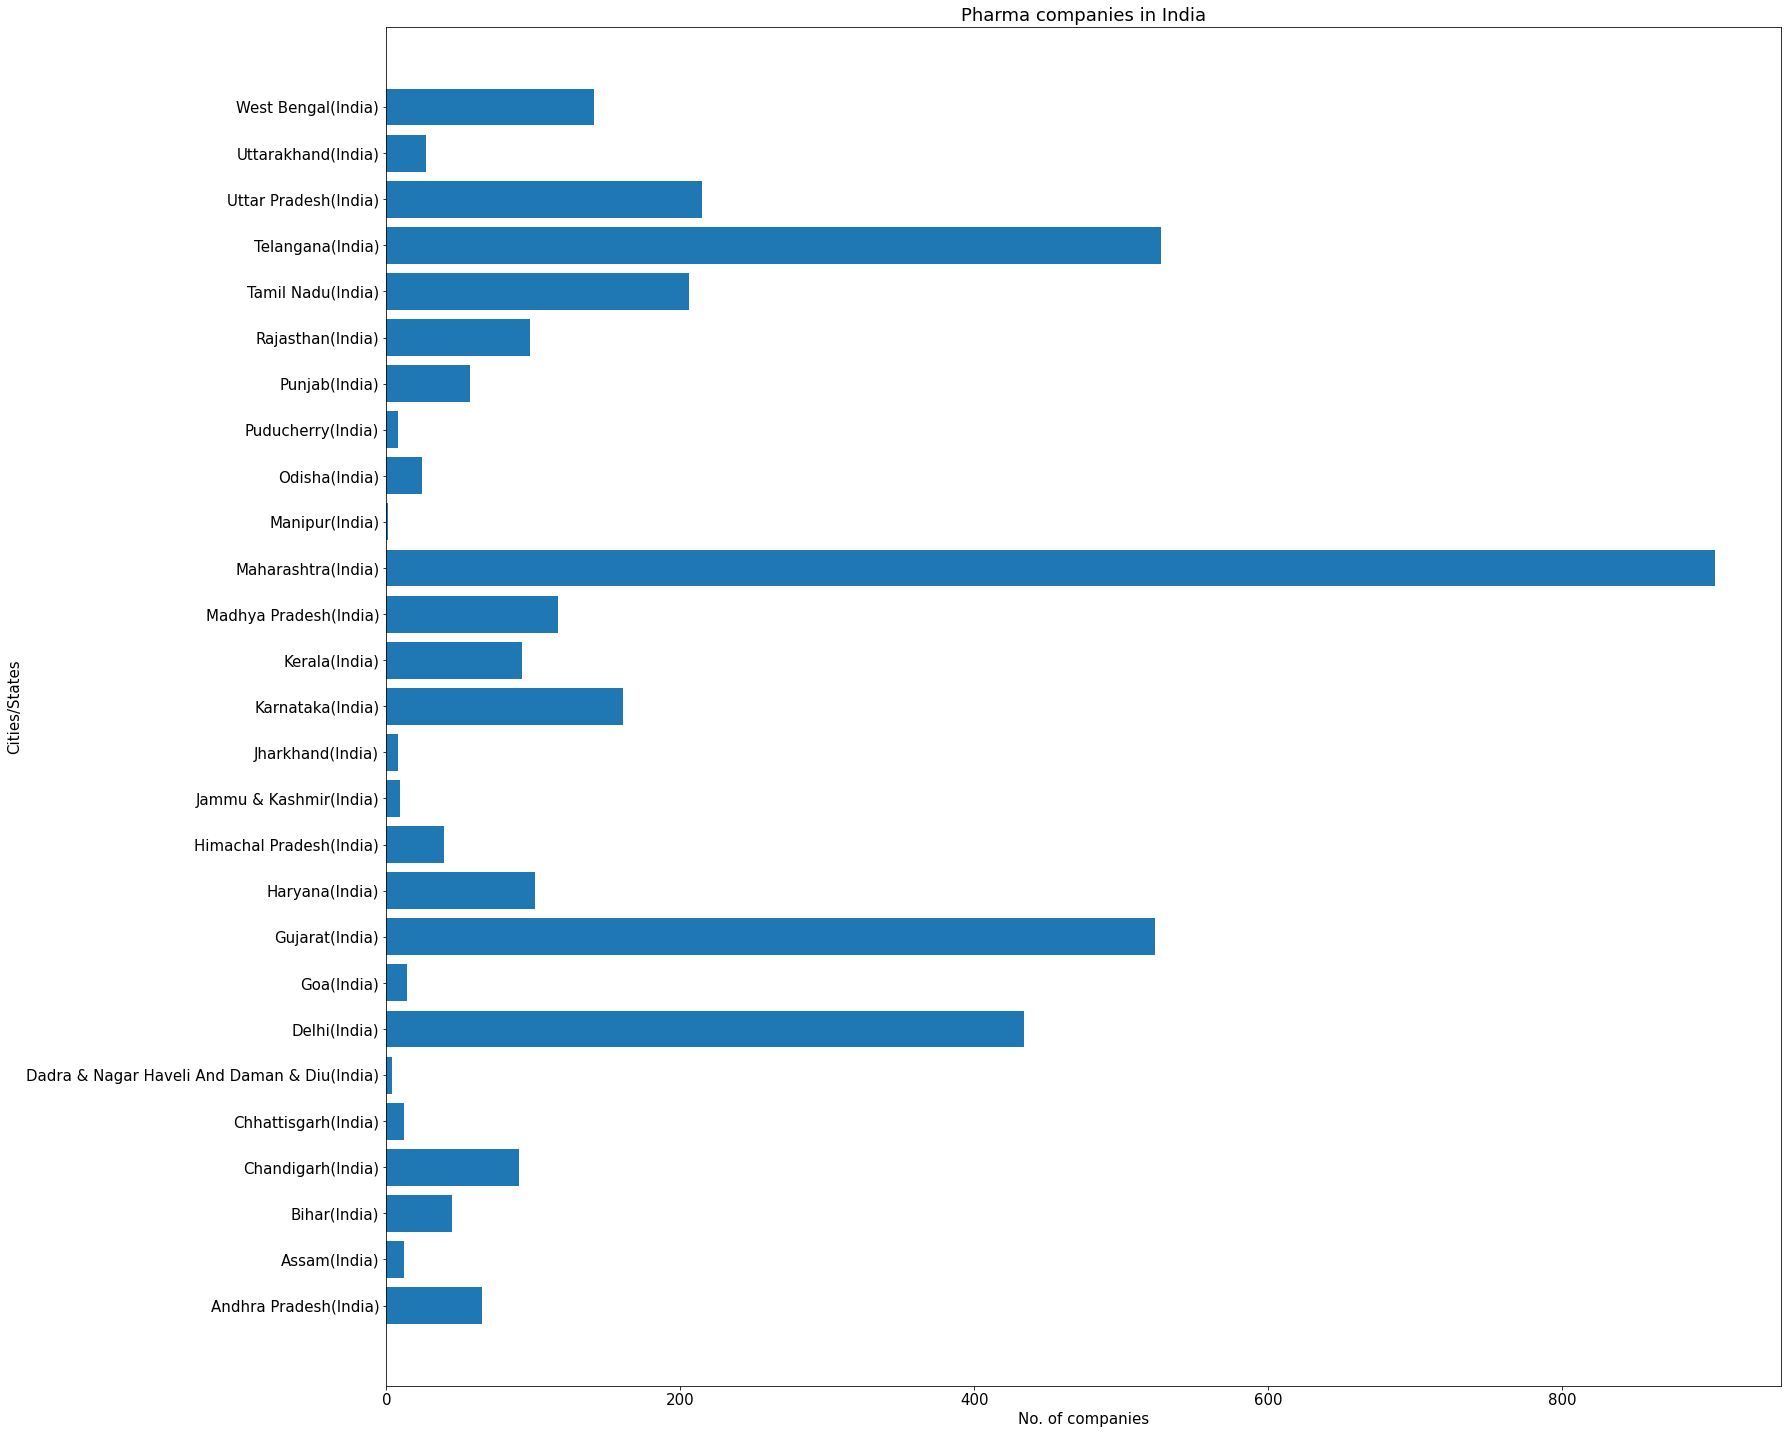

In [167]:
plotme(data_miner('Project_OPTEL_Asia/india_raw_data.xlsx'))

In [168]:
connpost()

enter db name: db_india


db created
connected to db_india


enter table name: india_companies


create table india_companies(
        company_name varchar,
        location varchar,
        location_type varchar,
        sales bigint,
        url varchar,
        phone_number float)
Table created


enter the file name that you want to open (with its extension): india_data.csv


File copied
